In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
reload(utils_jjm)

<module 'python_utils_jjm' from '/home/jma819/post_cmfe_analysis/python_utils_jjm.py'>

In [10]:
#'/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
#cnmfe_path = '/volumes/My_Passport/cnmfe_analysis_files/batch_output_files/08-Apr_16_03_01_out.mat'
CNMFE_file = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/08-Apr_16_03_01_out.mat'

In [34]:
# get fluorescence manipulations for whole session
cell_fluorescence = sio.loadmat(CNMFE_file)
C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)

#filter out small cells for analysis
C_normalized_z_scored_filtered = utils_jjm.filter_out_by_size(C_normalized_z_scored, cell_contours, 
                                                                  for_dims, 0.6, 100).drop(['msCamFrame'], axis=1)

In [29]:
# align frame inidcies in output file to session 
CNMFE_results = sio.loadmat(cnmfe_path)
#np.shape(CNMFE_results['C'])
file_array = CNMFE_results['P'][0][0][13]
session_names = []
frames_indicies = []
for session in range(len(file_array)):
    msCam_session = file_array[session][0][0].split('/')[8]
    frames = file_array[session][0][0].split('/')[10]
    frames_idx = frames.strip('frames_').split('_')
    session_names.append(msCam_session)
    frames_indicies.append(frames_idx)

total_frames = np.sum(np.array([(1+int(frames_indicies[session_idx][1]))-int(frames_indicies[session_idx][0]) for session_idx in range(len(session_names))]))

session_key = pd.DataFrame(frames_indicies, index=session_names)
session_key['cumulative_frames'] = np.nan*np.ones(len(session_names))
session_key = session_key.transpose()

final_frames = pd.DataFrame({k:v for k,v in zip(np.unique(np.array(session_names)), [session_key[session].loc[1].values[-1:] for session in np.unique(np.array(session_names))])}, index=['final_frame']).transpose()

final_frames['cumulative_frames'] = np.cumsum(np.array([int(frame) for frame in final_frames['final_frame'].values]))

final_frames

,final_frame,cumulative_frames
H19_M46_S0,1977,1977
H19_M51_S4,2561,4538
H19_M55_S57,3388,7926
H20_M0_S57,4712,12638
H20_M11_S42,5216,17854
H20_M17_S28,4574,22428
H20_M22_S56,4993,27421
H20_M28_S4,4370,31791
H20_M33_S18,5993,37784
H20_M6_S41,4465,42249


In [30]:
# pull out data by session
session = 'H19_M46_S0'
session_idx = np.where(np.array(final_frames.index)==session)[0][0]
frame_end = final_frames.iloc[session_idx]['cumulative_frames']
if session_idx != 0:
    frame_start = final_frames.iloc[session_idx-1]['cumulative_frames']
else:
    frame_start=0
frames=(frame_start, frame_end)
#start/stop indicies of session
frames

(0, 1977)

In [36]:
C_normalized_z_scored_filtered.head()

,1,2,3,4,5,6,7,8,9,10,...,135,136,137,139,140,141,142,145,148,149
00:00:00,-0.016964,-0.488173,-0.848195,0.035112,-0.539114,-0.248978,-0.601169,-0.191427,-0.083203,0.713918,...,-0.573771,0.434120,0.108201,-0.539150,-0.572728,0.199425,0.001017,0.114105,0.193691,-0.001258
00:00:00.050000,-0.031058,-0.488173,-0.849886,-0.002107,-0.351885,-0.284328,-0.601169,-0.247309,0.027174,0.669570,...,-0.573771,0.273558,-0.132712,-0.539150,-0.592176,0.095150,0.001683,0.138671,0.150173,-0.001258
00:00:00.100000,-0.044361,-0.488173,-0.851290,-0.037508,-0.337143,-0.317112,-0.601169,-0.241323,-0.015514,0.626795,...,-0.573771,0.133731,-0.287504,-0.486557,-0.610097,0.002003,-0.000357,0.058277,0.513741,-0.001258
00:00:00.150000,-0.056917,-0.488173,-0.852455,-0.071179,-0.364558,-0.347515,-0.601169,0.152217,0.008928,0.843185,...,-0.573771,0.711344,-0.129114,-0.498414,-0.626610,0.184154,0.006224,-0.010853,0.440547,-0.000480
00:00:00.200000,-0.006630,-0.488173,-0.853422,0.098700,-0.389397,-0.375710,-0.601169,0.041380,-0.031829,0.794252,...,-0.573771,0.514980,-0.285192,-0.507598,-0.641826,0.081510,0.003430,-0.070298,0.374140,-0.000753


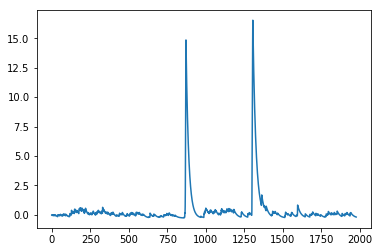

In [13]:
#plt.plot(C_normalized_z_scored[1].values[frames[0]:frames[1]])

In [ ]:
utils_jjm.get_ISIs()